# Clustering Neighborhoods in Toronto, Canada by Type of Venues

## Introduction

In this notebook, I will use the Foursquare API to explore and cluster the neighborhoods in the city of Toronto, Canada by prevalence of venue categories. 

The name of each neighborhood in Toronto will be scraped from a Wikipedia page, [List of postal codes of Canada: M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), by using the [BeautifulSoup package](https://beautiful-soup-4.readthedocs.io/en/latest/), and this data will be stored into a pandas dataframe.

The location data, such as Latitudes and Longitudes of each neighborhood, will be obtained by using the Geocoder Python package.


The Foursquare API provides data about venues and geolocation. The [explore endpoint of the Foursquare API](https://developer.foursquare.com/docs/api-reference/venues/explore/) will be used to get the most common venue categories in each neighborhood, and then these features will be used to group the neighborhoods into clusters. The k-means clustering algorithm will be used to complete this task. 

## Table of Contents

1.  <a href='item1'>Scrape postal codes, neighborhoods and boroughs from Wikipedia page</a> 
2.  <a href='item2'>Convert locations into geographic coordinates</a>
3.  <a href='item3'>Get the most common type of venues in all neighborhoods</a>
4.  <a href='item4'>Cluster the neighborhoods to find similar neighborhoods</a>
5.  <a href='item5'>Visualize and examine the final clusters</a>


## Import neccessary libraries

In [425]:
# library to handle data in a vectorized manner
import numpy as np 

# library for data analsysis
import pandas as pd 

# library to handle JSON files
import json 

# convert an address into latitude and longitude values
#!conda install -c conda-forge geocoder --yes
from geopy.geocoders import Nominatim
import geocoder

# library to handle requests
#!conda install -c conda-forge requests --yes
import requests 
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
#!conda install -c conda-forge matplotlib --yes
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
#!conda install -c conda-forge scipy --yes
from sklearn.cluster import KMeans

# map rendering library
#!conda install -c conda-forge folium --yes
import folium 

# library for scraping websites
#!conda install -c anaconda beautifulsoup4
from bs4 import BeautifulSoup

# Library for plotting
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>
## 1. Scrape postal codes, neighborhoods and boroughs from Wikipedia page

* Understanding and Inspecting the Data

Firstly, I will inspect the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) which I want to scrape. 

In [426]:
%%html
<iframe src="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" width="1100" height="500"></iframe>

As shown above, all the data needed for this project is contained in a table. To parse the postal code table, I am going to use the Python library BeautifulSoup.

In [427]:
# Website URL
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

# Search for the table
postal_code_table = soup.find("table", attrs={"class": "wikitable sortable"})

# Assign table data intto a pandas dataframe
df = pd.read_html(str(postal_code_table), header = 0, index_col = None)
table = pd.DataFrame(df[0])
table.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Now, we have to clean up the data in this table. The following steps will be taken:
1. Delete rows with a borough that is Not assigned.
2. If a row has a borough but a "Not assigned"  neighborhood, then the neighborhood will be the same as the borough.

In [428]:
# Delete rows with a borough that is Not assigned 
table = table[table.Borough != "Not assigned"].reset_index(drop=True)
# Assigned Borough name to "Not assigned neighborhood"
table.loc[table['Neighbourhood'] == "Not assigned", 'Neighbourhood'] = table.Borough
table.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


The final table has 3 columns and 103 rows.

In [429]:
# Check shape of the table
table.shape

(103, 3)

<a id='item2'></a>
## 2.  Convert locations into geographic coordinates

In order to use the Foursquare location data, we need to get the geographic coordinates (latitude and longitude) of each neighborhood. We will use the geocoder package in Python to get the geographical coordinates of each postal code.

In [430]:
latitude = []
longitude = []
for postal_code in table["Postal Code"]:
    # initialize variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        # obtain coordinates
        geo_coder = geocoder.arcgis('Toronto, Ontario, {}'.format(postal_code))
        lat_lng_coords = geo_coder.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

In [431]:
# Add latitude and longitude data to table
table["Latitude"] = latitude
table["Longitude"] = longitude
table.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75245,-79.32991
1,M4A,North York,Victoria Village,43.73057,-79.31306
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


Now that we have the geographical coordinates of all locations, let's create a map of Toronto with neighborhoods superimposed on top. I will use the folium library to plot the map. 

In [432]:
# Obtain geographical coordinates of Toronto
geo_coder = geocoder.arcgis('Toronto, Ontario')
latitude = geo_coder.latlng[0]
longitude = geo_coder.latlng[1]
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))

# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start = 10)

# Add markers to map
for lat, lng, borough, neighborhood, postal_code in zip(table['Latitude'], table['Longitude'], table['Borough'],table['Neighbourhood'], table['Postal Code']):
    label = 'Neighborhoods: {} \n Postal Code: {}'.format(neighborhood, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color ='purple',
        fill_opacity = 0.2,
        parse_html = False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto, Ontario are 43.648690000000045, -79.38543999999996.


<a id='item3'></a>
## 3. Get the most common type of venues in all neighborhoods.

For the scope of this analysis, we are only interested in exploring the neighborhoods that are part of the "Old Toronto", which are the neighborhoods that are part of the following boroughs: Downtown Toronto, East Toronto, Central Toronto, North Toronto, and West Toronto.

(39, 5)


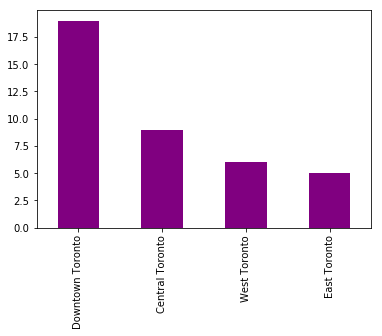

In [467]:
# extract boroughs that contain the string "toronto"
table = table[table["Borough"].str.contains("Toronto")].reset_index(drop=True)
print(table.shape)

# plot of counts of neighborhoods by borough
table["Borough"].value_counts().plot(kind='bar', color="purple")

We have a total of 39 locations divided as shown in the above plot. Half of the neighborhoods belongs to Downtown Toronto. 

Next, I am going to use the Foursquare API to explore the neighborhoods and get the top 100 venues that are in each location within a radius of 500 meters.

In [434]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'KD5JF0AA4HMHDUIFOKER0BQT0SFCC5ZCOBLLESAKKMR0LQMM' # Foursquare ID
CLIENT_SECRET = '5PI4ZBMSKM4UICZMNI5VF5LXVRRFWQJTPMJB20ZPYTVKJAOM' # Foursquare Secret
VERSION = '20201206' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

# Function that get the top 100 venues that are in each neighborhood within a radius of 500 meters.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        # Create the GET request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, LIMIT) 
        
        # Send the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Get relevant information for each nearby venue
        venues_list.append([(name,
                             lat,
                             lng,
                             v['venue']['name'], 
                             v['venue']['location']['lat'], 
                             v['venue']['location']['lng'],  
                             v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
        
    return(nearby_venues)

Now, let's run the getNearbyVenues function on each location and create a new dataframe called toronto_venues.

In [435]:
# Calling getNearbyVenues function
toronto_venues = getNearbyVenues(table['Neighbourhood'], table['Latitude'], table['Longitude'], radius=500)
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.62513,-79.52681,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.62513,-79.52681,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.62513,-79.52681,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.62513,-79.52681,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
4,"Regent Park, Harbourfront",43.62513,-79.52681,The Yoga Lounge,43.655515,-79.364955,Yoga Studio


Let's see how many vanues were returned by Foursquare, and how many unique categories there are from all the returned venues.

In [436]:
# get dataframe shape
print('There are {} venues'.format( toronto_venues.shape[0]))
# unique type of venues
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 1704 venues
There are 228 unique categories.


<a id='item4'></a>
## 3. Cluster Neighborhoods

In order to use k-mean clustering we have to convert the categorical variable "Venue Category" into dummy variables. 

In [437]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot.insert(loc=0, column ='Neighborhood Name', value = toronto_venues["Neighborhood"])
toronto_onehot.head()

,Neighborhood Name,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Next, I will group the rows by neighborhood and by taking the mean frequency of occurrence of each venue category.

In [440]:
# Group rows by neighborhood and canculate mean frequency of courrence of each venue category
toronto_grouped = toronto_onehot.groupby("Neighborhood Name").mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(39, 229)


,Neighborhood Name,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Berczy Park,0.000000,0.0,0.00,0.015625,0.0,0.015625,0.000000,0.000000,0.000000,...,0.0,0.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.015625
1,"Brockton, Parkdale Village, Exhibition Place",0.011628,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.023256,0.000000,...,0.0,0.000000,0.011628,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.011628
2,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.02,0.000000,0.0,0.010000,0.000000,0.000000,0.030000,...,0.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.010000,0.0,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.013158,...,0.0,0.013158,0.000000,0.013158,0.000000,0.000000,0.000000,0.0,0.0,0.013158
4,Central Bay Street,0.000000,0.0,0.00,0.000000,0.0,0.016129,0.016129,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.016129,0.016129,0.016129,0.0,0.0,0.000000


Now, we will use k-means to clusters the nieghborhoods. Since we don't know the number of clusters present in this dataset (k), we will use the inertia attribute to identify the optimal value of k.

In [448]:
# Define the parameter values that should be searched
N = 7
k_range = [*range(1, N)]

X = toronto_grouped.drop('Neighborhood Name', 1) # feauture matrix

inertia=[] # List of inertia from k_range

# run k-means clustering
for k in k_range:
        kmeans = KMeans(n_clusters= k, random_state = 0).fit(X)
        inertia.append(kmeans.inertia_)

Next, we will plot the values of k versus the inertia values and use the elbow method to determine the optimal k value.

Text(0.5, 1.0, 'The Elbow Method using Inertia')

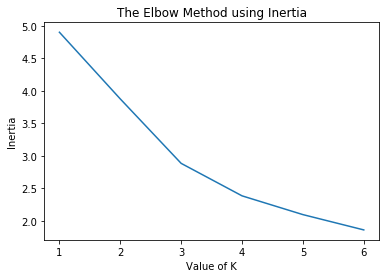

In [449]:
# Plot the value of K (x-axis) versus inertia (y-axis)
plt.plot(k_range, inertia)
plt.xlabel('Value of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia') 

According to the Elbow graph we deterrmine the clusters number as 4.

In [450]:
#Fit Model with optimal k
k = 4
kmeans = KMeans(n_clusters= k, random_state = 0).fit(X)

Let's now create a final dataframe that contains the cluster membership as well as the top 10 venues for each neighborhood. The venue categories with the 10 highest mean frequency of ocurrance will be considered the top 10 venues for each neighborhood.

In [451]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood Name']

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,"Brockton, Parkdale Village, Exhibition Place",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,"Business reply mail Processing Centre, South C...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,"CN Tower, King and Spadina, Railway Lands, Har...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Central Bay Street,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [452]:
# return most common venues in neighborhood      
def return_most_common_venues(row, num_top_venues):
    
    row_categories = row.iloc[1:]

    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# add top 10 venues
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
    
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = table
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() 

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,0,Coffee Shop,Breakfast Spot,Yoga Studio,Thai Restaurant,Gym / Fitness Center,Pub,Distribution Center,Restaurant,Electronics Store,Event Space
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,0,Coffee Shop,Sandwich Place,Italian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Café,Fried Chicken Joint,Bank,Theater,Gastropub
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,0,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Hotel,Middle Eastern Restaurant,Sandwich Place,Ramen Restaurant,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.65215,-79.37587,0,Coffee Shop,Cosmetics Shop,Gastropub,Cocktail Bar,Clothing Store,Café,Italian Restaurant,Hotel,Seafood Restaurant,Gym
4,M4E,East Toronto,The Beaches,43.67709,-79.29547,0,Health Food Store,Pub,Trail,Asian Restaurant,Neighborhood,Donut Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


<a id='item5'></a>
## 4. Visualize and examine the final clusters

Let's visualize the resulting clusters.

In [453]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

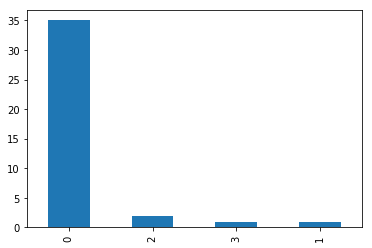

In [480]:
# Count total number of neighboorhoods by cluster
toronto_merged['Cluster Labels'].value_counts().plot(kind='bar')

The majority of the neighborhoods (35) are grouped in one cluster (Cluster 0), which indicates that the same type of venues are popular in the majority of the neighborhoods in Toronto. There is only 1 neighborhood in Clusters 1 and Clusters 3, and 2 in Cluster 2.

We can now examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [458]:
# Examine 10 top venues in CLuster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2] + [*range(5, toronto_merged.shape[1])]]]


,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Regent Park, Harbourfront",0,Coffee Shop,Breakfast Spot,Yoga Studio,Thai Restaurant,Gym / Fitness Center,Pub,Distribution Center,Restaurant,Electronics Store,Event Space
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Sandwich Place,Italian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Café,Fried Chicken Joint,Bank,Theater,Gastropub
2,Downtown Toronto,"Garden District, Ryerson",0,Coffee Shop,Clothing Store,Cosmetics Shop,Japanese Restaurant,Café,Hotel,Middle Eastern Restaurant,Sandwich Place,Ramen Restaurant,Bookstore
3,Downtown Toronto,St. James Town,0,Coffee Shop,Cosmetics Shop,Gastropub,Cocktail Bar,Clothing Store,Café,Italian Restaurant,Hotel,Seafood Restaurant,Gym
4,East Toronto,The Beaches,0,Health Food Store,Pub,Trail,Asian Restaurant,Neighborhood,Donut Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
5,Downtown Toronto,Berczy Park,0,Coffee Shop,Cocktail Bar,Bakery,Farmers Market,Seafood Restaurant,Restaurant,Beer Bar,Cheese Shop,Lounge,Breakfast Spot
6,Downtown Toronto,Central Bay Street,0,Coffee Shop,Clothing Store,Hotel,Middle Eastern Restaurant,Plaza,Sandwich Place,Bubble Tea Shop,Cosmetics Shop,Burger Joint,Shopping Mall
7,Downtown Toronto,Christie,0,Café,Grocery Store,Playground,Italian Restaurant,Coffee Shop,Candy Store,Baby Store,Athletics & Sports,Ethiopian Restaurant,Elementary School
8,Downtown Toronto,"Richmond, Adelaide, King",0,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Steakhouse,American Restaurant,Salad Place,Asian Restaurant
9,West Toronto,"Dufferin, Dovercourt Village",0,Park,Furniture / Home Store,Pharmacy,Pool,Smoke Shop,Café,Middle Eastern Restaurant,Bar,Bank,Bakery


With plenty of coffe shops and restaurants, “Food” seems to be the most popular venue category in the neighborhoods that make up Cluster 0.

In [482]:
# Examine 10 top venues in CLuster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2] + [*range(5, toronto_merged.shape[1])]]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,1,Home Service,Yoga Studio,Dog Run,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant


The neighborhood Roselawn in Central Toronto differentiates from the rest by having a high frequency of venues that provide home services.

In [483]:
# Examine 10 top venues in CLuster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2] + [*range(5, toronto_merged.shape[1])]]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",2,Park,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room
33,Downtown Toronto,Rosedale,2,Park,Playground,Bike Trail,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant


Outdoors and recreational venues such as parks seems to be the most popular venue category in the neighborhoods that make up Cluster 2. Rosedale is the only neighborhood in Dowtown Toronto that is not part of Cluster 0, with popular outdoor venues. 

In [485]:
# Examine 10 top venues in CLuster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2] + [*range(5, toronto_merged.shape[1])]]]

,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,Lawrence Park,3,Bus Line,Swim School,Yoga Studio,Donut Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant


The bus lines seem to be the most popular venue category in the neighborhood Lawrence Park which makes up CLuster 3. This makes sense since this neighborhood is the farthest from Downtown Toronto. Swim schools seem to be the second most popular venue category in the neighborhood.